In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rand
import statistics


In [2]:
data_frame = pd.read_csv('A2Q1.csv', header=None)
data = data_frame.values
D = data.shape[1]
N = data.shape[0]

Note that we will be interpreting the 1s in the data as head and the 0s as tails

In [3]:
def init_bern(K, D):
    pi = np.random.uniform(1e-7, 1-1e-7, K)
    pi_sum = np.sum(pi)
    pi /= pi_sum

    p = np.random.uniform(1e-7, 1-1e-7, size = (K, D))
    return pi, p

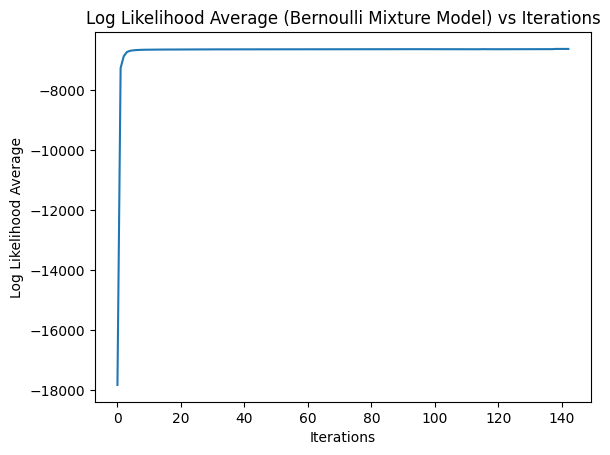

In [4]:
K = 4

num_inits = 100
LL_vals = []
maxitr = 0
tolerance = 1e-3

for _ in range(num_inits):
    pi, p = init_bern(K, D)
    itr = 0
    lamda = np.ones((N, K))
    for k in range(K):
            lamda[:, k] = pi[k] * np.prod(np.power(p[k], data) * np.power((1-p[k]), (1-data)), axis=1)
    lamda_sum = np.sum(lamda, axis=1)
    LL = sum([np.log(lamda_sum[i]) for i in range(N)])
    while True:
        #E step
        for k in range(K):
            lamda[:, k] = pi[k] * np.prod(np.power(p[k], data) * np.power((1-p[k]), (1-data)), axis=1)
        lamda_sum = np.sum(lamda, axis=1)
        lamda = lamda / np.sum(lamda, axis=1, keepdims=True)
        #M step
        pi = np.sum(lamda, axis=0) / N
        p = np.matmul(lamda.T, data) / np.sum(lamda, axis=0)[:, np.newaxis]

        LL_new = sum([np.log(lamda_sum[i]) for i in range(N)])
        if(itr>0 and np.abs(LL_new - LL) < tolerance):
            break
        if(len(LL_vals)<= itr):
            LL_vals.append([LL_new])
        else:
            LL_vals[itr].append(LL_new)
        itr+= 1
        if(itr>maxitr):
            maxitr = itr
        LL = LL_new

LL_avg = [statistics.mean(LL_vals[i]) for i in range(maxitr)]

plt.plot(range(len(LL_avg)), LL_avg)
plt.xlabel('Iterations')
plt.ylabel('Log Likelihood Average')
plt.title('Log Likelihood Average (Bernoulli Mixture Model) vs Iterations')
plt.show()


In [5]:
def init_gmm(K, D):
    pi = np.random.uniform(1e-7, 1-1e-7, K)
    pi_sum = np.sum(pi)
    pi /= pi_sum

    mu = np.random.uniform(1e-7, 1 - 1e-7, size = (K, D))
    sigma = np.array([np.eye(D) for _ in range(K)])
    return pi, mu, sigma

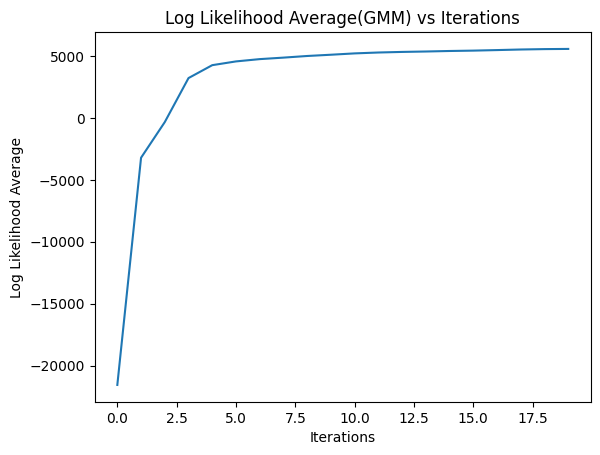

In [6]:
K = 4
num_inits = 100
LL_vals = []
maxitr = 0
tolerance = 1e-3
LL_averages = np.zeros(20)
for _ in range(num_inits):
    pi, mu, sigma = init_gmm(K, D)
    itr = 0
    lamda = np.ones((N, K))

    for k in range(K):
            lamda[:, k] = pi[k] * np.prod(np.power(p[k], data) * np.power((1-p[k]), (1-data)), axis=1)
    lamda_sum = np.sum(lamda, axis=1)
    LL = sum([np.log(lamda_sum[i]) for i in range(N)])
    for ii in range(20):
        # E step
        lamda = np.ones((N, K))
        for k in range(K):
            temp = (data - mu[k])@( np.linalg.inv(sigma[k]))@(data - mu[k]).T
            a = ((2*np.pi)**(D/2))*np.sqrt(np.linalg.det(sigma[k]))
            for i in range (N):
                lamda[i, k] = pi[k]*np.exp(-0.5*temp[i][i])/a
        
        lamda_sum = np.sum(lamda, axis=1)
        lamda = lamda / np.sum(lamda, axis=1, keepdims=True)

        # M step
        pi = np.sum(lamda, axis=0) / N
        mu = np.matmul(lamda.T, data) / np.sum(lamda, axis=0)[:, np.newaxis]
        sigma = np.zeros((K, D, D))
        for k in range(K):
            for d in range(D):
                sigma[k][d][d] += 1e-6

        for k in range(K):
            for i in range(N):
                sigma[k] += lamda[i, k] * np.outer(data[i] - mu[k], data[i] - mu[k])
            sigma[k] /= np.sum(lamda[:, k])

        # LL_new = sum([np.log(lamda_sum[i]) for i in range(N)])
        LL_new = np.sum(np.log(lamda_sum))
        # if(itr>0 and np.abs(LL_new - LL) < tolerance):
        #    break
        if(len(LL_vals)<= itr):
            LL_vals.append([LL_new])
        else:
            LL_vals[itr].append(LL_new)
        itr+= 1
        if(itr>maxitr):
            maxitr = itr
        LL = LL_new
        LL_averages[ii] += LL_new
LL_averages = LL_averages/100

#LL_avg = [statistics.mean(LL_vals[i]) for i in range(maxitr)]

plt.plot(range(len(LL_averages)), LL_averages)
plt.xlabel('Iterations')
plt.ylabel('Log Likelihood Average')
plt.title('Log Likelihood Average(GMM) vs Iterations')
plt.show()

In [7]:
def lloyds_algo(data, num_clusters):
    np.random.seed(0)
    D = data[0].size
    n = data[:,0].size
    num_points_in_clusters = np.zeros(num_clusters)
    z_assignment = np.random.randint(0, num_clusters, n) 
    for i in range(n):
        num_points_in_clusters[z_assignment[i]]+=1
    z_prev_assignment = np.zeros(n).astype(int)
    Error = []
    means = np.full((num_clusters, D), 0.0, dtype='float64')
    for j in range(num_clusters):
        count =0
        sum_data = np.full((1, D), 0.0, dtype='float64')
        for i in range(n):
            if(z_assignment[i]==j):
                sum_data+=data[i]
                count+=1
        sum_data/=count
        means[j] = sum_data
    
    while True:
        error = 0.0
        #  Reassignment
        for i in range(n):
            z_prev_assignment[i] = z_assignment[i]
            # error+=((x_vals[i]-means[z_assignment[i]][0])**2 + (y_vals[i]-means[z_assignment[i]][1])**2)
            for j in range(D):
                error+=(data[i][j]-means[z_assignment[i]][j])**2
            
            dist = []
            for j in range(len(means)):
                dist_sum = 0.0
                for k in range(D):
                    dist_sum+=(data[i][k]-means[j][k])**2                    
                dist.append(dist_sum)
            z_assignment[i] = np.argmin(dist)
            num_points_in_clusters[z_prev_assignment[i]]-=1
            num_points_in_clusters[z_assignment[i]]+=1
            if(num_points_in_clusters[z_prev_assignment[i]]==0):
                z_assignment[i] = z_prev_assignment[i]
                num_points_in_clusters[z_assignment[i]]-=1
                num_points_in_clusters[z_prev_assignment[i]]+=1
        if(np.array_equal(z_assignment, z_prev_assignment)):
            break
        Error.append(error)
        #  Mean calculation
        for j in range(num_clusters):
            count = 0
            sum_data = np.full((1, D), 0.0, dtype='float64')
            for i in range(n):
                if(z_assignment[i]==j):
                    sum_data+=data[i]
                    count+=1
            sum_data/=count
            means[j] = sum_data
    return z_assignment, Error


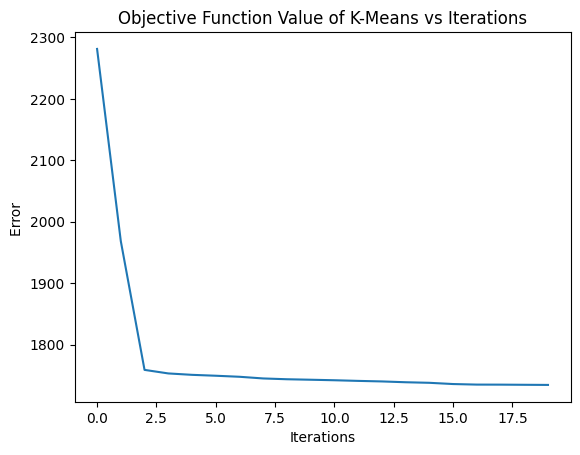

In [8]:
z_assignment, Error = lloyds_algo(data, 4)
plt.plot(range(len(Error)), Error)
plt.xlabel('Iterations')
plt.ylabel('Error ')
plt.title('Objective Function Value of K-Means vs Iterations')
plt.show()